# 2D Pose Estimation

In [1]:
%matplotlib inline

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np

## Build the dataset

![Dataset Joints](res/joints.png)

In [2]:
IMG_FOLDER = 'images'
release = loadmat('mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')['RELEASE']

In [3]:
for i in release['annolist'][0,0][0]:
    if i['image']['name'][0,0][0] == '050985401.jpg':
        print(i['annorect']['annopoints'][0,0][0,0][0].shape)
        break
#release['annolist'][0,0][0][4]['annorect']['annopoints'].shape

(1, 12)


In [4]:
release['img_train'][0,0][0][2]

0

In [5]:
data = []
d_c = 0

# Code adapted from: https://github.com/mitmul/deeppose/blob/master/datasets/mpii_dataset.py
for i, anno in enumerate(release['annolist'][0, 0][0]):

    img_fn = anno['image']['name'][0, 0][0]
    head_rect = []
    
    if release['img_train'][0,0][0][i] == 0:
        d_c += 1

    if 'annopoints' in str(anno['annorect'].dtype):
        annopoints = anno['annorect']['annopoints'][0]
        head_x1s = anno['annorect']['x1'][0]
        head_y1s = anno['annorect']['y1'][0]
        head_x2s = anno['annorect']['x2'][0]
        head_y2s = anno['annorect']['y2'][0]

        count = 0
        h = []
        j = []
        discard = False
        for annopoint, head_x1, head_y1, head_x2, head_y2 in zip(annopoints, head_x1s, head_y1s, 
                                                                 head_x2s, head_y2s):
            count += 1
            if annopoint != []:
                head_rect = [float(head_x1[0, 0]),
                             float(head_y1[0, 0]),
                             float(head_x2[0, 0]),
                             float(head_y2[0, 0])]

                # joint coordinates
                annopoint = annopoint['point'][0, 0]
                j_id = [j_i[0, 0] for j_i in annopoint['id'][0]]
                x = [x[0, 0] for x in annopoint['x'][0]]
                y = [y[0, 0] for y in annopoint['y'][0]]
                joint_pos = {}
                for _j_id, (_x, _y) in zip(j_id, zip(x, y)):
                    joint_pos[_j_id] = [float(_x), float(_y)]
                    
                h.append(head_rect)
                j.append(joint_pos)

        data.append({'filename': img_fn,
                     'n_people': count,
                     'head_rect': h,
                     'joint_pos': j
                    })
                    

/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
/home/xabilahu/Documents/EHU/Cuarto/PrimerCuatrimestre/MLNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


### Split into train-test

__NOTE__: We ignore the default train - test annotations because of examples with missing joint annotations. We first get the annotated examples, and then perform the train-test split.

In [6]:
train, test = train_test_split(data, test_size=0.1)
del data

Test examples are not annotated, and some training examples (671) miss joint annotations.

In [7]:
len(train) + len(test) + d_c # Different from 

24316

### Visualize some train data

In [8]:
joint_unions = [(8, 12), (12, 11), (11, 10), (8, 13), (13, 14), (14, 15), (8, 7), (7, 6), (6, 2), \
                (2, 1), (1, 0), (6, 3), (3, 4), (4, 5)]

def plot_example(data_dict):
    """
    Input:
        - data_dict: dictionary with fields ['filename', 'head_rect', 'visibility_mask', 'joint_pos']
    Output:
        - plot of the image with the joint skeletons drawn above
    """
    img = mpimg.imread(f'{IMG_FOLDER}/{data_dict["filename"]}')
    plt.figure(figsize=(16,16))
    plt.imshow(img)
    
    for i in range(data_dict['n_people']):
        plt.plot([data_dict['head_rect'][i][0], data_dict['head_rect'][i][0]], 
                 [data_dict['head_rect'][i][1], data_dict['head_rect'][i][3]],
                 c='blue', lw=3)
        plt.plot([data_dict['head_rect'][i][0], data_dict['head_rect'][i][2]], 
                 [data_dict['head_rect'][i][3], data_dict['head_rect'][i][3]],
                 c='blue', lw=3)
        plt.plot([data_dict['head_rect'][i][2], data_dict['head_rect'][i][2]], 
                 [data_dict['head_rect'][i][1], data_dict['head_rect'][i][3]],
                 c='blue', lw=3)
        plt.plot([data_dict['head_rect'][i][0], data_dict['head_rect'][i][2]], 
                 [data_dict['head_rect'][i][1], data_dict['head_rect'][i][1]],
                 c='blue', lw=3)

        for o, t in joint_unions:
            try:
                plt.plot([data_dict['joint_pos'][i][o][0], data_dict['joint_pos'][i][t][0]], 
                         [data_dict['joint_pos'][i][o][1], data_dict['joint_pos'][i][t][1]],
                         lw=3)
            except KeyError:
                pass
    
    plt.axis('off')
    

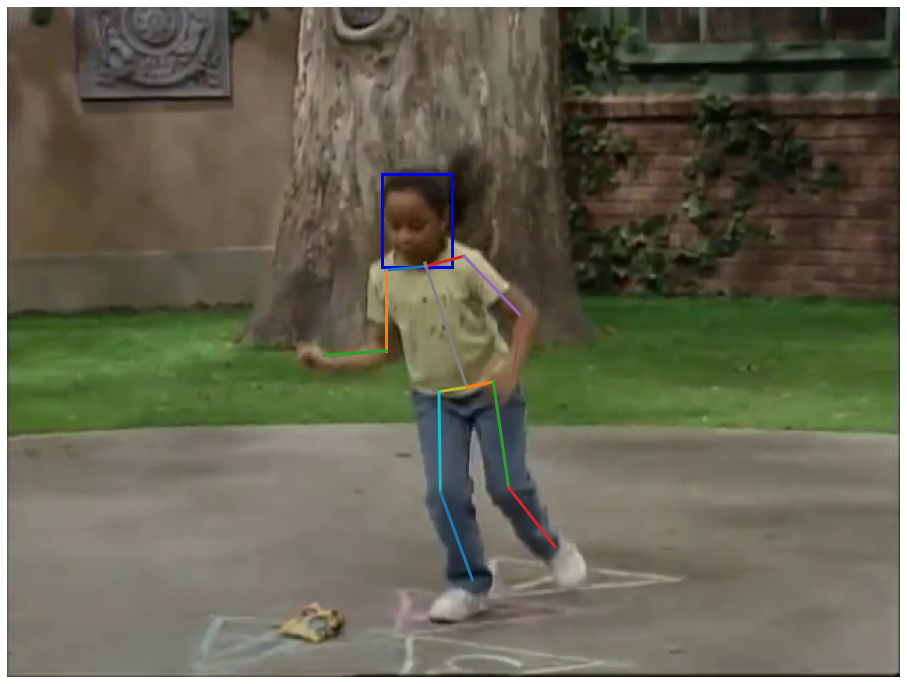

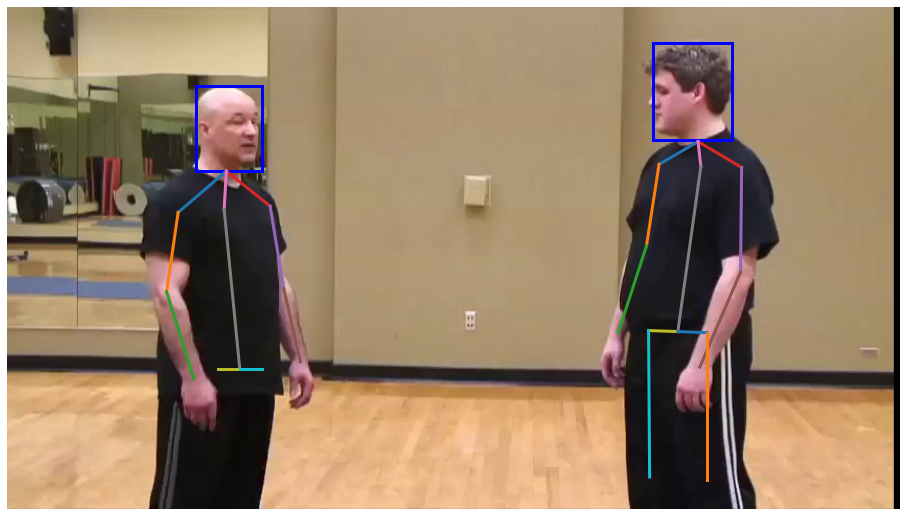

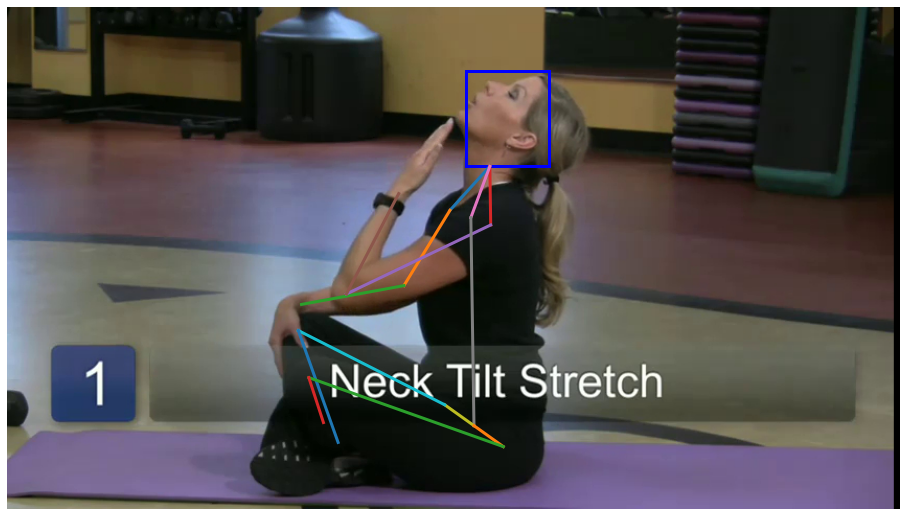

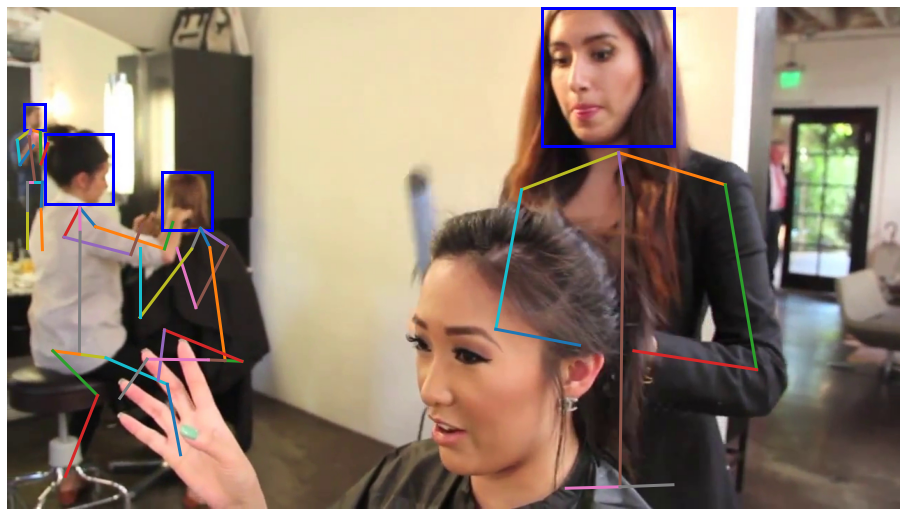

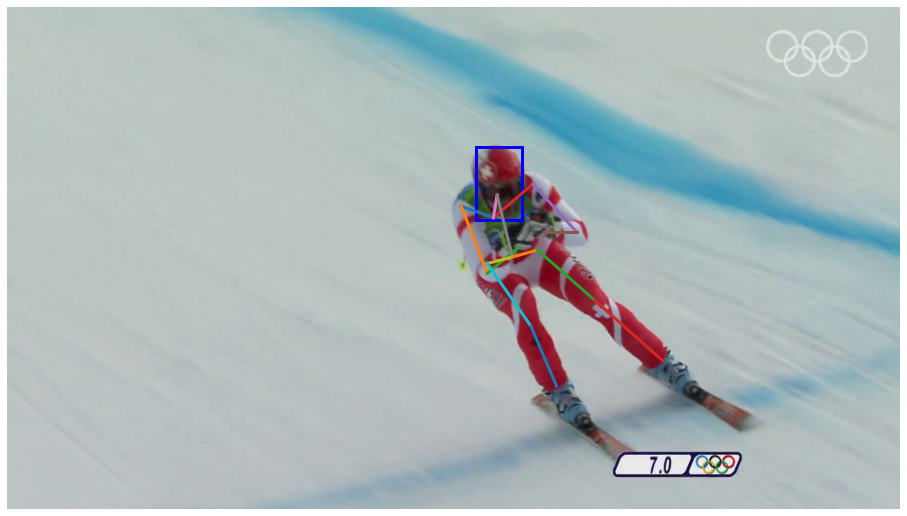

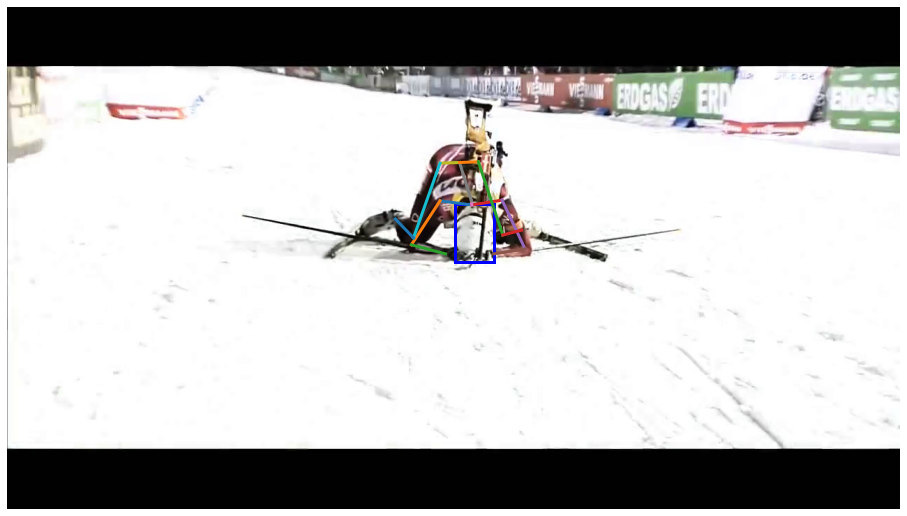

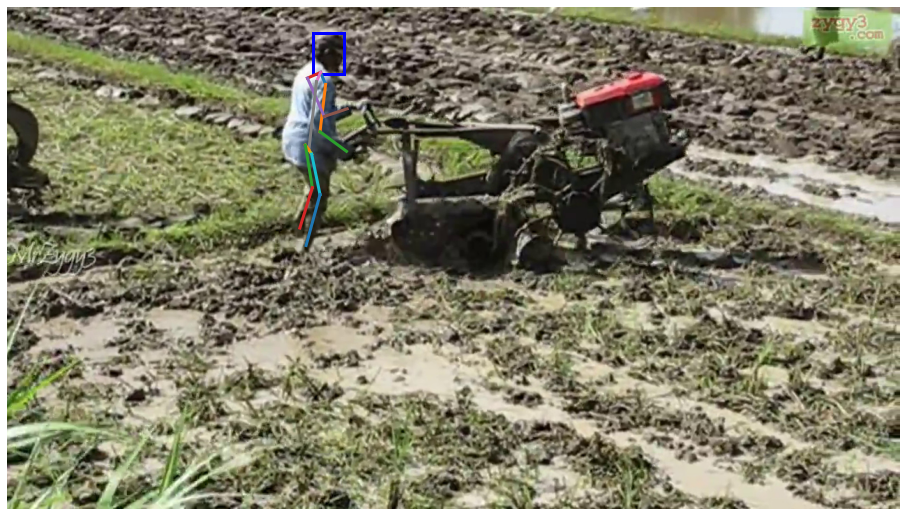

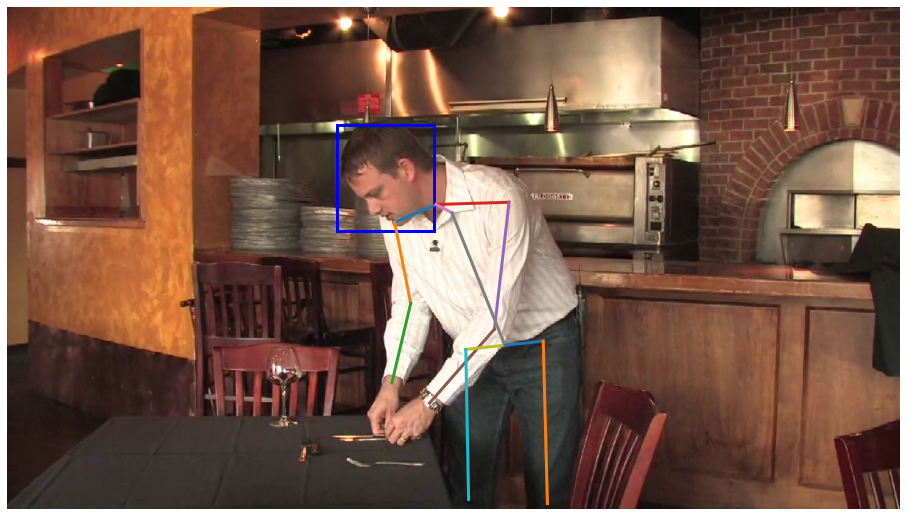

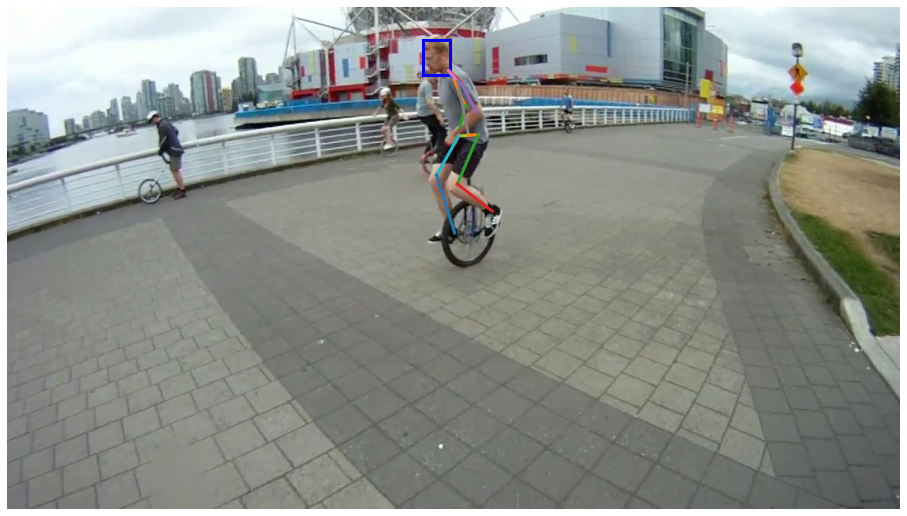

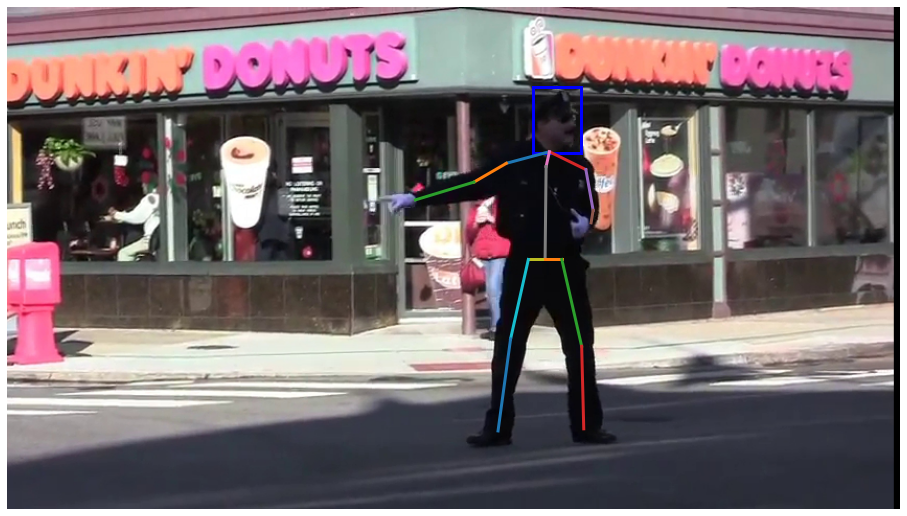

In [9]:
for i in range(10):
    plot_example(train[i+40])

## Preprocessing

In [10]:
# TODO: crop images w.r.t. humans and standarize to 256x256x3